# Araçların Yakıt Tüketimi Tahmini Projesi 

## Importing Libraries

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from scipy import stats
from scipy.stats import norm, skew

In [2]:
from sklearn.preprocessing import RobustScaler, StandardScaler
from sklearn.linear_model import LinearRegression, Ridge, Lasso, ElasticNet
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import mean_squared_error
from sklearn.base import BaseEstimator, TransformerMixin, RegressorMixin, clone

In [3]:
import xgboost as xgb
import warnings
warnings.filterwarnings('ignore')

## Problem Desciption & Importing Data

In [4]:
column_name = ["MPG", "Cylinders", "Displacement","Horsepower","Weight","Acceleration","Model Year", "Origin"]
data = pd.read_csv("auto-mpg.data", names = column_name, na_values = "?", comment = "\t",sep = " ", skipinitialspace = True)

In [5]:
data = data.rename(columns = {"MPG" : "target"}) # changing dependent variable name

In [6]:
data.head()

,target,Cylinders,Displacement,Horsepower,Weight,Acceleration,Model Year,Origin
0,18.0,8,307.0,130.0,3504.0,12.0,70,1
1,15.0,8,350.0,165.0,3693.0,11.5,70,1
2,18.0,8,318.0,150.0,3436.0,11.0,70,1
3,16.0,8,304.0,150.0,3433.0,12.0,70,1
4,17.0,8,302.0,140.0,3449.0,10.5,70,1


In [7]:
data.shape

(398, 8)

In [8]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 398 entries, 0 to 397
Data columns (total 8 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   target        398 non-null    float64
 1   Cylinders     398 non-null    int64  
 2   Displacement  398 non-null    float64
 3   Horsepower    392 non-null    float64
 4   Weight        398 non-null    float64
 5   Acceleration  398 non-null    float64
 6   Model Year    398 non-null    int64  
 7   Origin        398 non-null    int64  
dtypes: float64(5), int64(3)
memory usage: 25.0 KB


In [9]:
 # missing values observed in Horsepower column
 # tüm variablelar numerical değere sahip
 # origin categorical variable olarak değerlendirilebilir. One hot encoding kullanarak yeni featurelar çıkarılabilir

In [10]:
describe= data.describe()

## Missing Values

In [11]:
print(data.isna().sum())

target          0
Cylinders       0
Displacement    0
Horsepower      6
Weight          0
Acceleration    0
Model Year      0
Origin          0
dtype: int64


In [12]:
data['Horsepower'] = data['Horsepower'].fillna(data['Horsepower'].mean()) #filled null values from Horsepower with mean value

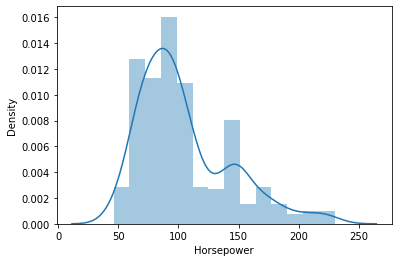

In [13]:
sns.distplot(data.Horsepower)
plt.show()

## Exploratory Data Analysis

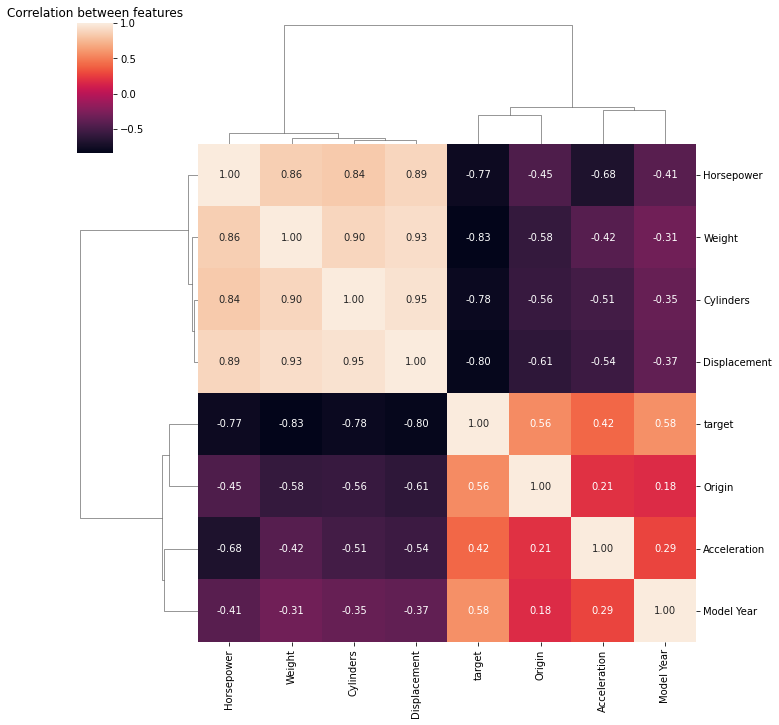

In [14]:
# numeric featurelar arasında korelasyona bakmakla başla
corr_matrix = data.corr()
sns.clustermap(corr_matrix, annot=True, fmt='.2f')
plt.title('Correlation between features')
plt.show()

Horsepower, Weight, cylinders ve Displacement birbirileri ile pozitif korelasyona sahip.
Target variable ise bu dördüyle negatif korelasyona sahip.
Sağ alt köşede korelasyon pek yok.

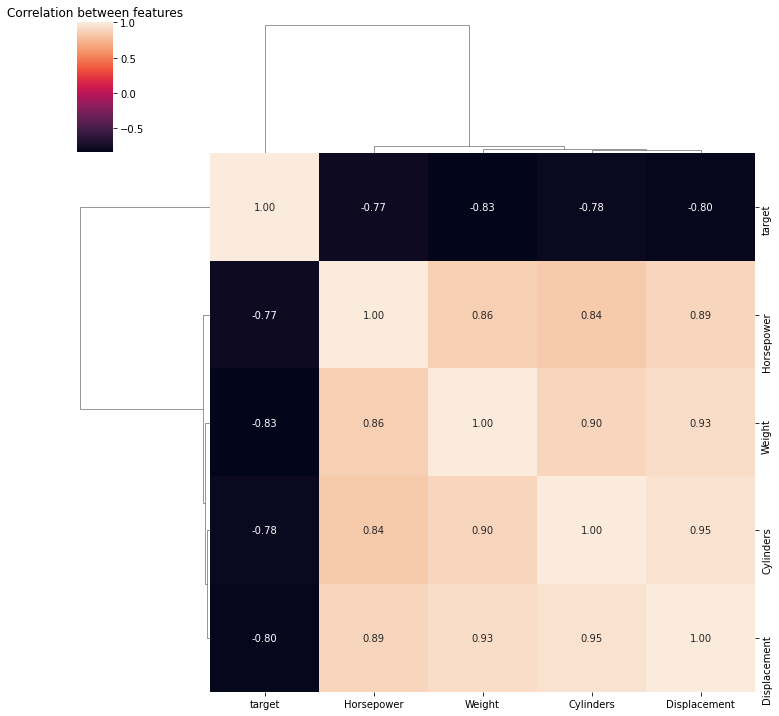

In [15]:
threshold = 0.75
filtre = np.abs(corr_matrix['target'])> threshold
corr_features = corr_matrix.columns[filtre].tolist()
sns.clustermap(data[corr_features].corr(), annot=True, fmt='.2f')
plt.title('Correlation between features')
plt.show() # multicollinearity

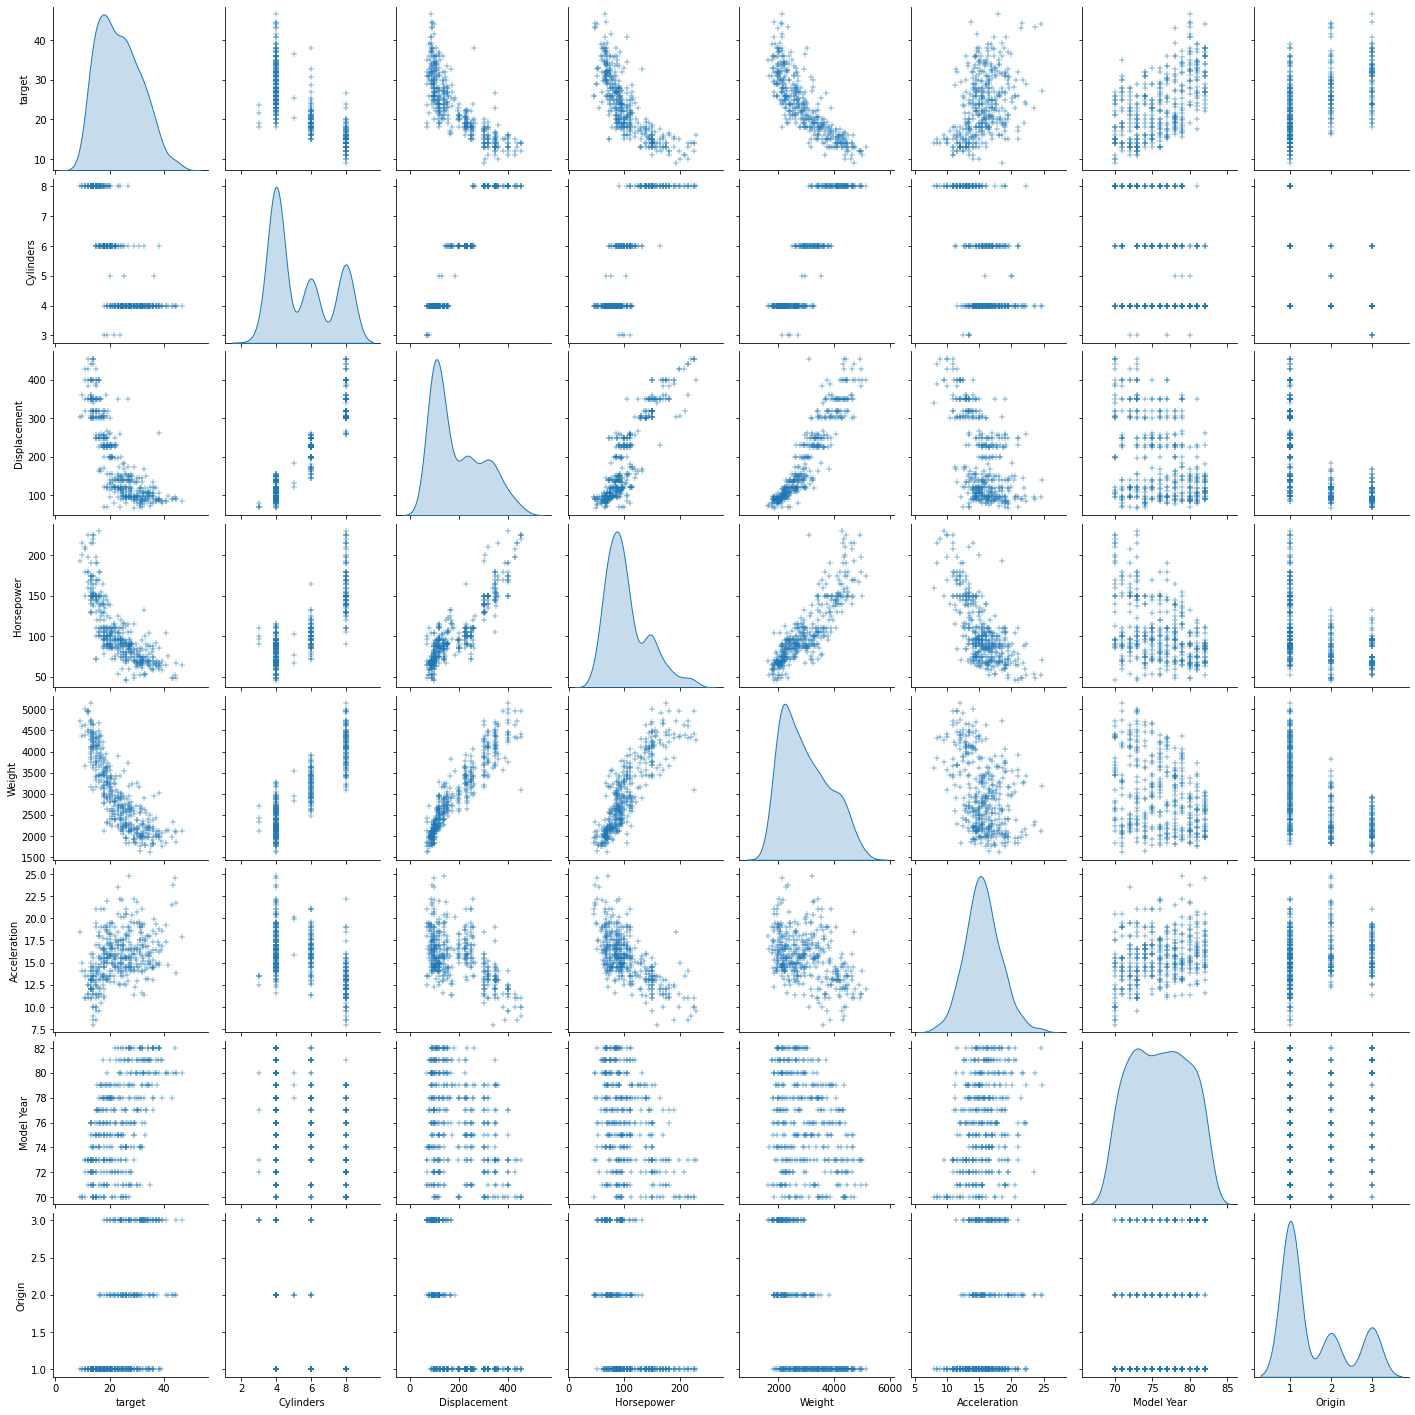

In [16]:
sns.pairplot(data, diag_kind='kde', markers ='+')
plt.show()

In [17]:
# cylinders and origin can be categorical(feature engineering)

4    204
8    103
6     84
3      4
5      3
Name: Cylinders, dtype: int64


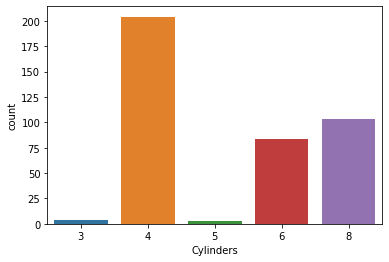

In [18]:
plt.figure()
sns.countplot(data['Cylinders'])
print(data['Cylinders'].value_counts())

1    249
3     79
2     70
Name: Origin, dtype: int64


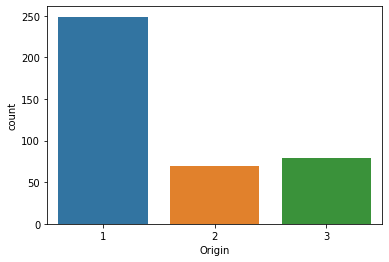

In [19]:
plt.figure()
sns.countplot(data['Origin'])
print(data['Origin'].value_counts())

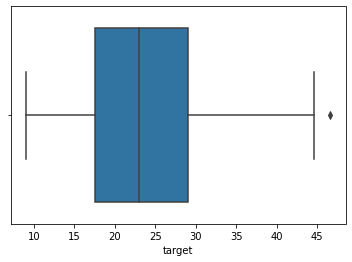

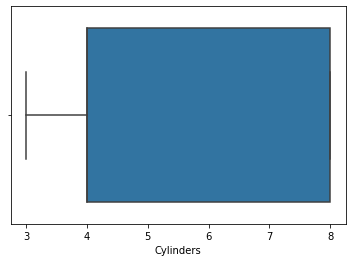

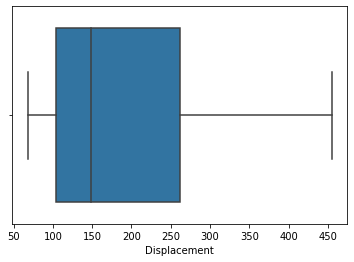

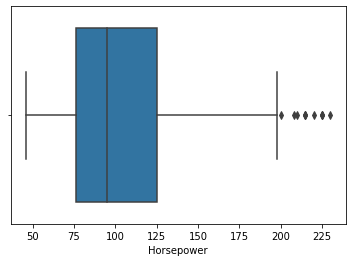

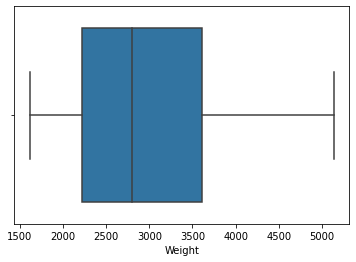

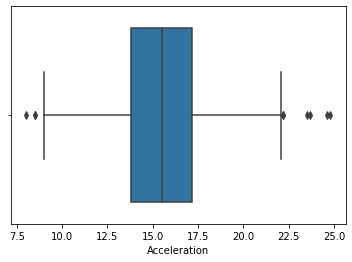

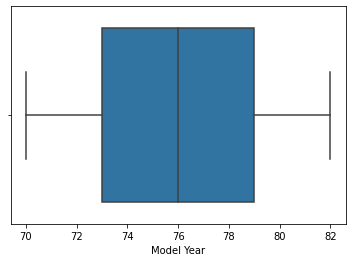

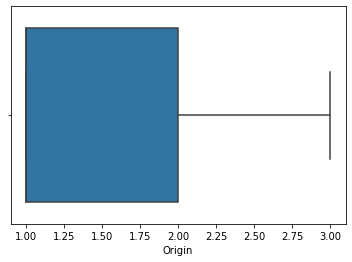

In [20]:
for c in data.columns:
    plt.figure()
    sns.boxplot(x= c, data = data, orient = "v" )

In [21]:
# outlier: horsepower and acceleration

## Outliers

In [22]:
thr=2
horsepower_desc= describe['Horsepower']
horsepower_desc

count    392.000000
mean     104.469388
std       38.491160
min       46.000000
25%       75.000000
50%       93.500000
75%      126.000000
max      230.000000
Name: Horsepower, dtype: float64

In [23]:
q3_hp=horsepower_desc[6]
q1_hp=horsepower_desc[4]
IQR_hp=q3_hp - q1_hp
top_limit_hp = q3_hp + thr*IQR_hp
bottom_limit_hp= q1_hp - thr*IQR_hp
filter_hp_bottom = bottom_limit_hp < data['Horsepower']
filter_hp_top = data['Horsepower'] < top_limit_hp
filter_hp= filter_hp_bottom & filter_hp_top
data = data[filter_hp]

In [24]:
acceleration_desc= describe['Acceleration']
q3_acc=acceleration_desc[6]
q1_acc=acceleration_desc[4]
IQR_acc=q3_acc - q1_acc
top_limit_acc = q3_acc + thr*IQR_acc
bottom_limit_acc= q1_acc - thr*IQR_acc
filter_acc_bottom = bottom_limit_acc < data['Acceleration']
filter_acc_top = data['Acceleration'] < top_limit_acc
filter_acc= filter_acc_bottom & filter_acc_top
data = data[filter_acc]

## Feature Engineering

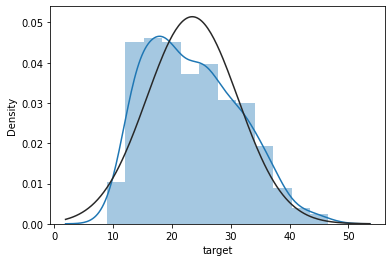

In [25]:
sns.distplot(data.target, fit= norm)
plt.show()

In [26]:
(mu, sigma) = norm.fit(data['target'])
print("mu : {}, sigma : {}".format(mu, sigma))

mu : 23.472405063291134, sigma : 7.756119546409932


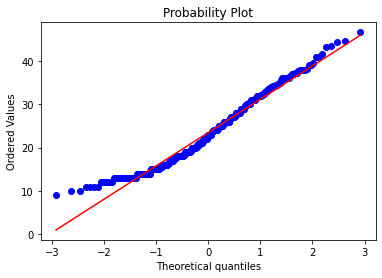

In [27]:
# qqplot
plt.figure()
stats.probplot(data['target'], plot= plt)
plt.show()

<AxesSubplot:xlabel='target', ylabel='Density'>

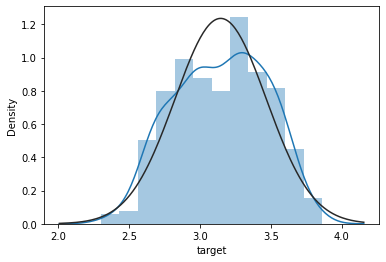

In [28]:
# logtransform
data['target'] = np.log1p(data['target'])
plt.figure()
sns.distplot(data.target, fit= norm)

In [29]:
(mu, sigma) = norm.fit(data['target'])
print("mu : {}, sigma : {}".format(mu, sigma))

mu : 3.146474056830183, sigma : 0.3227569103044823


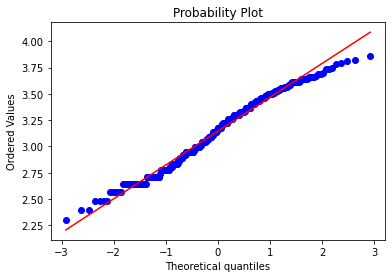

In [30]:
plt.figure()
stats.probplot(data['target'], plot= plt)
plt.show()

In [31]:
# feature = independent variable
skewed_feats= (data.apply(lambda x: skew(x.dropna())).sort_values(ascending=False))
skewness = pd.DataFrame(skewed_feats, columns = ['skewed'])
skewness
# Box Cox Transformation

,skewed
Horsepower,1.067743
Origin,0.923381
Displacement,0.714682
Weight,0.533226
Cylinders,0.523374
Acceleration,0.168986
Model Year,0.013098
target,-0.117687


### One Hot Encoding

In [32]:
# cylinder & origin 
data['Cylinders'] = data['Cylinders'].astype(str) # str ile object yaptık, categorical oldu
data['Origin'] = data['Origin'].astype(str)
data = pd.get_dummies(data) # datanın içindeki categorica değerleri one hot encoding yapıyor
data.head()

,target,Displacement,Horsepower,Weight,Acceleration,Model Year,Cylinders_3,Cylinders_4,Cylinders_5,Cylinders_6,Cylinders_8,Origin_1,Origin_2,Origin_3
0,2.944439,307.0,130.0,3504.0,12.0,70,0,0,0,0,1,1,0,0
1,2.772589,350.0,165.0,3693.0,11.5,70,0,0,0,0,1,1,0,0
2,2.944439,318.0,150.0,3436.0,11.0,70,0,0,0,0,1,1,0,0
3,2.833213,304.0,150.0,3433.0,12.0,70,0,0,0,0,1,1,0,0
4,2.890372,302.0,140.0,3449.0,10.5,70,0,0,0,0,1,1,0,0


## Split Standartization

In [33]:
x = data.drop(['target'], axis=1)
y = data.target

In [34]:
test_size=0.9
X_train, X_test, y_train, y_test = train_test_split(x, y, test_size= test_size, random_state=42)

In [35]:
#standatdization
scaler = RobustScaler() #RobustScaler
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)
# mean = 0, STD =1 haline geldi

## Regression Models

### Linear Regression

In [36]:
lr = LinearRegression()
lr.fit(X_train, y_train)
print('LR Coef:', lr.coef_)
y_predicted_dummy = lr.predict(X_test)
mse = mean_squared_error(y_test, y_predicted_dummy)
print('Linear Regression MSE: ', mse)

LR Coef: [-1.52652234e-01 -1.10059003e-01 -3.51567523e-02 -7.81023601e-02
  7.76057988e-02 -2.71614700e-01  1.86827885e-01 -2.51534904e-17
  5.74192760e-02  2.73675388e-02 -1.43431578e-02 -6.77254422e-02
  8.20686000e-02]
Linear Regression MSE:  0.020984711065869677


###  Ridge Regression (Regularization - 1)

In [37]:
# L2 regularization : min(least square error + lambda * (slope)**2)
# for prevent overfitting

ridge = Ridge( random_state = 42, max_iter = 10000)
alphas = np.logspace(-4, -0.5, 30)
tuned_parameters = [ { 'alpha' : alphas}]
n_folds = 5
clf = GridSearchCV(ridge, tuned_parameters, cv= n_folds, scoring = 'neg_mean_squared_error', refit= True)
clf.fit(X_train, y_train)
scores = clf.cv_results_["mean_test_score"]
scores_std = clf.cv_results_['std_test_score']
print("Ridge Coef : ", clf.best_estimator_.coef_)
ridge = clf.best_estimator_
print("Ridge Best Estimator : ", ridge)
y_predicted_dummy = clf.predict(X_test)
mse = mean_squared_error(y_test, y_predicted_dummy)
print("Ridge MSE : ", mse)

Ridge Coef :  [-0.07617499 -0.10434789 -0.0756786  -0.06362033  0.08849698 -0.17538752
  0.17840625  0.          0.02717488 -0.03019362 -0.02334111 -0.05192496
  0.07526607]
Ridge Best Estimator :  Ridge(alpha=0.31622776601683794, max_iter=10000, random_state=42)
Ridge MSE :  0.018839299330570585


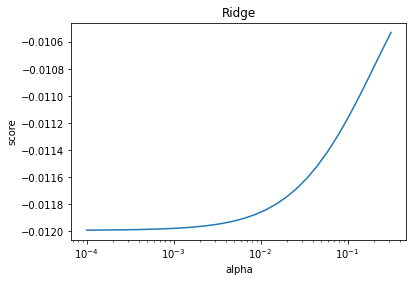

In [38]:
plt.figure()
plt.semilogx(alphas, scores)
plt.xlabel("alpha")
plt.ylabel("score")
plt.title("Ridge")
plt.show()

###  Lasso Regression (Regularization - 2)

In [39]:
# L1 regularization : min(least square error + lambda * abs(slope))
# gereksiz coefficientlar sıfır oluyor (ridge den farkı)
# high corelated featurelardan en önemlisini seçip kullanıyor, diğerleri sıfır
# varyansı azaltarak overfittingi önlüyor
lasso = Lasso( random_state = 42, max_iter = 10000)
alphas = np.logspace(-4, -0.5, 30)
tuned_parameters = [ { 'alpha' : alphas}]
n_folds = 5
clf = GridSearchCV(lasso, tuned_parameters, cv= n_folds, scoring = 'neg_mean_squared_error', refit= True)
clf.fit(X_train, y_train)
scores = clf.cv_results_["mean_test_score"]
scores_std = clf.cv_results_['std_test_score']
print("Lasso Coef : ", clf.best_estimator_.coef_)
lasso = clf.best_estimator_
print("Lasso Best Estimator : ", lasso)
y_predicted_dummy = clf.predict(X_test)
mse = mean_squared_error(y_test, y_predicted_dummy)
print("Lasso MSE : ", mse)

Lasso Coef :  [-0.01692687 -0.10976505 -0.11721736 -0.03064576  0.09866154 -0.01243765
  0.16495225  0.          0.00378698 -0.00505995 -0.         -0.
  0.07376033]
Lasso Best Estimator :  Lasso(alpha=0.0037065129109221566, max_iter=10000, random_state=42)
Lasso MSE :  0.016597127172690847


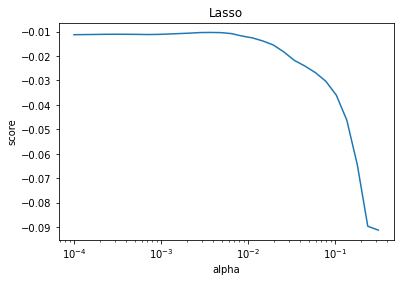

In [40]:
plt.figure()
plt.semilogx(alphas, scores)
plt.xlabel("alpha")
plt.ylabel("score")
plt.title("Lasso")
plt.show()

###  ElasticNet (Regularization - 3)

In [41]:
# min(least square error + lambda * abs(slope) + lambda * (slope)**2)
# lasso & ridge karışımı, her ikisinin de penalty termlerini kullanıyor
# highly corr variable çıkartılmasında işe yarıyor

parametersGrid = { "alpha" : alphas, "l1_ratio" : np.arange(0.0, 1.0, 0.05)}

eNet = ElasticNet(random_state = 42, max_iter = 10000)

clf = GridSearchCV(eNet, parametersGrid, cv= n_folds, scoring = 'neg_mean_squared_error', refit= True)
clf.fit(X_train, y_train)
print("ElasticNet Coef : ", clf.best_estimator_.coef_)

eNet = clf.best_estimator_
print("ElasticNet Best Estimator : ", eNet)

y_predicted_dummy = clf.predict(X_test)
mse = mean_squared_error(y_test, y_predicted_dummy)
print("ElasticNet MSE : ", mse)

ElasticNet Coef :  [-0.0518437  -0.10923982 -0.09538543 -0.03946691  0.09541227 -0.07791667
  0.14374215  0.          0.         -0.01852327 -0.         -0.00200172
  0.0793579 ]
ElasticNet Best Estimator :  ElasticNet(alpha=0.014873521072935119, l1_ratio=0.15000000000000002,
           max_iter=10000, random_state=42)
ElasticNet MSE :  0.017234676963922283


In [42]:
#STANDARDSCALER RESULTS

# Linear Regression MSE:  0.00020711611616699426
# Ridge MSE :  0.0001964983001269467
# Lasso MSE :  0.00019489199808125652
# ElasticNet MSE :  0.00017499038026292204

In [43]:
# ROBUSTSCALER RESULTS

# Linear Regression MSE:  00.00020561982306479092
# Ridge MSE :  0.00019196140757286084
# Lasso MSE :  0.00018682953775408238
# ElasticNet MSE :  0.0001827307205773426

## XGBoost

In [45]:
parametersGrid = {'nthread': [4],
    'objective': ['reg:linear'],
    'learning_rate': [0.03, 0.05, 0.07],
    'max_depth': [5 , 6, 7],
    'min_child_weight': [4],
    'silent': [1],
    'subsample': [0.7],
    'colsample_bytree': [0.7],
    'n_estimators': [500, 1000]
}


model_xgb = xgb.XGBRegressor()
clf = GridSearchCV(model_xgb, parametersGrid, cv= n_folds, scoring = 'neg_mean_squared_error', refit= True, n_jobs = 5)
clf.fit(X_train, y_train)
model_xgb = clf.best_estimator_

y_predicted_dummy = clf.predict(X_test)
mse = mean_squared_error(y_test, y_predicted_dummy)
print("XGBRegressor MSE : ", mse)

[22:19:56] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/objective/regression_obj.cu:171: reg:linear is now deprecated in favor of reg:squarederror.
[22:19:57] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:573: 
Parameters: { "silent" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


XGBRegressor MSE :  0.017444718427058307


### Averaging Models

In [ ]:
class AveragingModels():
    def __init__(self, models):
        self.models=models
        
    def fit(self, X, y):
        self.models_ = [clone(x) for x in self.models]
        
        for model in self.models_:
            model.fit(X,y)
            
        return self
    
    def predict(self, X):
        predictions = np.column_stack([model.predict(X) for model in self.models_])
        return np.mean(predictions, axis =1)

In [ ]:
averaged_models = AveragingModels(models =( model_xgb, ridge))
averaged_models.fit(X_train, y_train)

y_predicted_dummy = averaged_models.predict(X_test)
mse = mean_squared_error(y_test, y_predicted_dummy)
print("averaged_models MSE : ", mse)